# Exercise 7

In [1]:
import numpy as np
import cv2 
import matplotlib.pyplot as plt
from skimage.transform import hough_line, hough_line_peaks
import utilis

Learning objectives
These exercises will introduce you to robust model fitting. You will find straight lines with the
Hough transform, and then implement RANSAC to do the same

Hough Transform
Here you should extract lines from the image Box3.bmp from last week, via the Hough transform.
The image should be found together with this exercise. Perform the following steps:

Exercise 7.1
Load the image and detect edges in it. Here the function cv2.Canny can be used. Visualize the
edges you have detected.


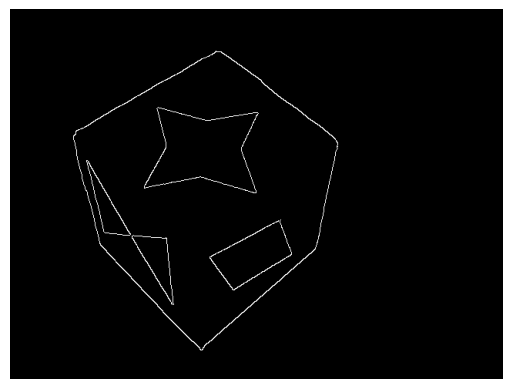

In [2]:
box = cv2.imread("images/Box3.bmp", cv2.IMREAD_GRAYSCALE)
edges = utilis.edge_detection(box, 100, 500)
plt.imshow(edges, cmap='gray')
plt.axis('off')
plt.show()

Exercise 7.2
Compute the Hough space from the detected edges. Use the function
hspace, angles, dists = skimage.transform.hough_line(edges)
What do the returned values hspace, angles, dists mean?

In [3]:
hspace, angles, dists = hough_line(edges)
# hspace: Hough transform accumulator
# angles: Angles at which the transform is computed, in radians (theta)
# dists: Distance values at which the transform is computed (r)
print(f"hspace shape: {hspace.shape}")
print(f"angles range: {angles.min()}, {angles.max()}")
print(f"dists range: {dists.min()}, {dists.max()}")
print(f"angles: {len(angles)}")
print(f"dists: {len(dists)}")

hspace shape: (1601, 180)
angles range: -1.5707963267948966, 1.5533430342749535
dists range: -800.0, 800.0
angles: 180
dists: 1601


What do the returned values hspace, angles, dists mean?

hspace: It is the Hough space, a 2D array where each element represents the number of votes for a potential line in the image. The dimensions of this array are determined by the resolution of the discretization of the Hough space, specifically, the angle (theta) and the distance (rho) resolution.

angles: It is a 1D array containing the angles (in radians) for which the Hough transform was computed. These angles correspond to the theta axis of the Hough space.

dists: It is a 1D array containing the distances for which the Hough transform was computed. These distances correspond to the rho axis of the Hough space and represent the distance from the origin to the detected line along the normal vector defined by the corresponding angle.

This information from the Hough transform is used to identify lines in the image, where each line is represented by a pair of values: a distance (rho) and an angle (theta). The hspace matrix accumulates "votes" for potential lines that pass through the image. A high number of votes in a particular cell indicates a high likelihood of a line existing at that specific angle and distance from the origin.

Exercise 7.3 Visualize the Hough space. To get the correct units on the axes you can use

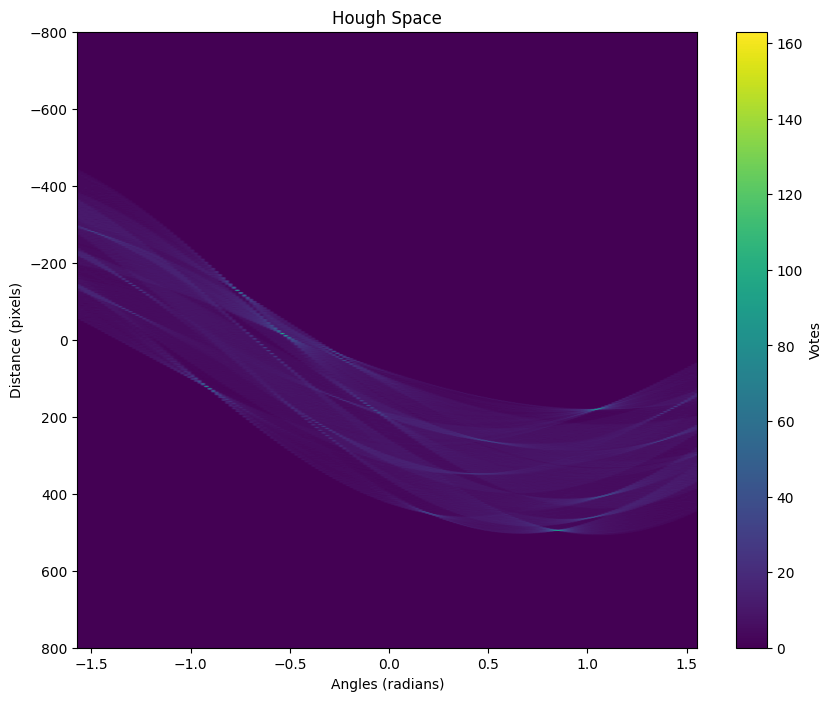

In [4]:
extent = [angles[0], angles[-1], dists[-1], dists[0]]
plt.figure(figsize=(10, 8))
plt.imshow(hspace, extent=extent, aspect='auto')
plt.xlabel('Angles (radians)')
plt.ylabel('Distance (pixels)')
plt.title('Hough Space')
plt.colorbar(label='Votes')

Exercise 7.4
Find peaks in your Hough space, using skimage.transform.hough_line_peaks.
extH, extAngles, extDists = hough_line_peaks(hspace, angles, dists, num_peaks=n)
Display your identified peaks on top of the Hough space.

Peaks in Hough space:
Peak 1: Angle (radians) = 0.8552, Distance = 495.00, Accumulator Value = 163
Peak 2: Angle (radians) = 1.0472, Distance = 180.00, Accumulator Value = 158
Peak 3: Angle (radians) = -0.5411, Distance = -17.00, Accumulator Value = 155
Peak 4: Angle (radians) = -0.7679, Distance = -129.00, Accumulator Value = 135
Peak 5: Angle (radians) = -0.9250, Distance = 121.00, Accumulator Value = 112


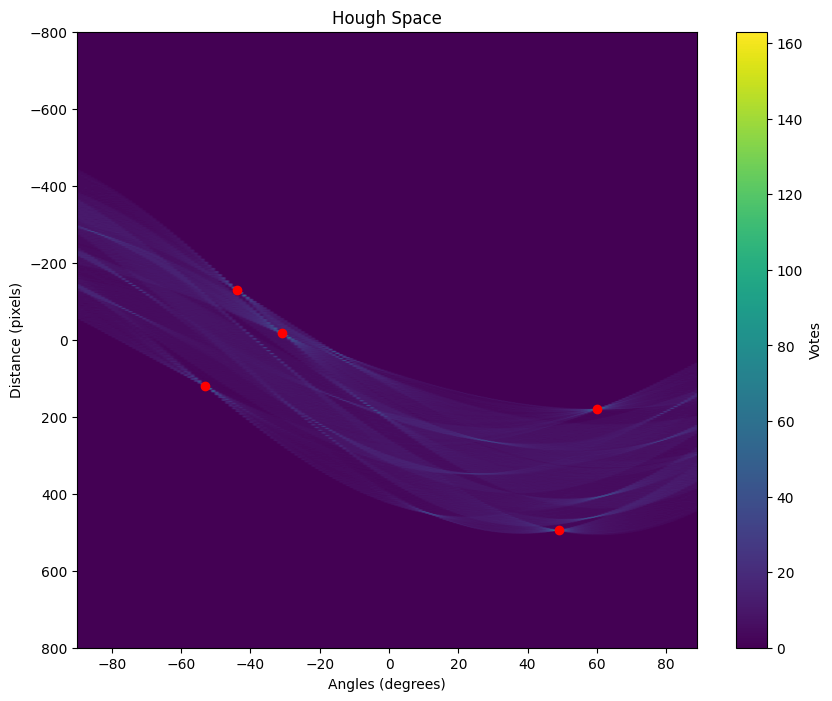

[163 158 155 135 112]


In [5]:
# Visualize the Hough space
extent = [np.rad2deg(angles[0]), np.rad2deg(angles[-1]), dists[-1], dists[0]]
plt.figure(figsize=(10, 8))
plt.imshow(hspace, extent=extent, aspect='auto')
plt.xlabel('Angles (degrees)')
plt.ylabel('Distance (pixels)')
plt.title('Hough Space')
plt.colorbar(label='Votes')

# Find peaks in the Hough space
hspace_peaks, angles_peaks, dists_peaks = hough_line_peaks(hspace, angles, dists, num_peaks=5)
# hspace_peaks: Hough transform accumulator values at the peaks
# angles_peaks: Angles at which the peaks are found, in radians
# dists_peaks: Distance values at which the peaks are found
print("Peaks in Hough space:")
for i, (angle, dist, value) in enumerate(zip(angles_peaks, dists_peaks, hspace_peaks)):
    print(f"Peak {i+1}: Angle (radians) = {angle:.4f}, Distance = {dist:.2f}, Accumulator Value = {value}")
# Display identified peaks on top of the Hough space
for angle, dist in zip(angles_peaks, dists_peaks):
    plt.plot(np.rad2deg(angle), dist, 'ro')

plt.show()

print(hspace_peaks)


*hspace_peaks*: Values in the accumulator that correspond to the peaks. This is the number of votes or the magnitude of each peak in the Hough space.

*angles_peaks*: The angles at which these peaks occur. These values are typically in radians and correspond directly to the angles used in the Hough transform.

*dists_peaks*: The distances from the origin to the line corresponding to each peak. These are the radial distances in the polar coordinates used in the Hough transform.

Line from (-429.96036087247097, 1029.6402712007794) to (1079.458799573073, -282.47778678023514)
Line from (-776.0254037844387, 655.8845726811988) to (956.0254037844387, -344.1154273188009)
Line from (500.4662307981182, 865.9229479755833) to (-529.60991902199, -848.4116534286414)
Line from (601.8635362153113, 808.9507301278619) to (-787.4532047026833, -629.7288705494406)
Line from (871.4551278486907, 505.18012643632596) to (-725.815892245895, -698.4499198677709)


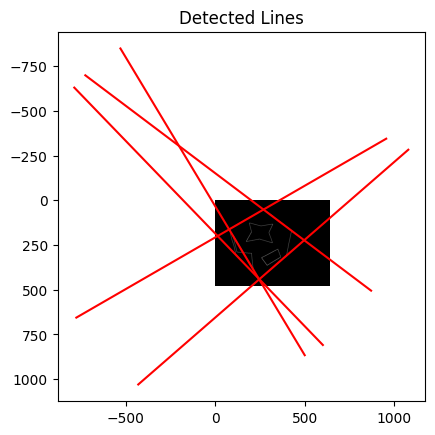

In [6]:
# Create a blank image/display area
fig, ax = plt.subplots()

# Display the original image with edges
ax.imshow(edges, cmap='gray')

# Iterate through each peak to plot the lines
for angle, dist in zip(angles_peaks, dists_peaks):
    (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
    # These are the direction vectors along the line
    delta_x = 1000 * np.sin(angle)
    delta_y = 1000 * -np.cos(angle)

    # Define the line's start and end points
    x1 = x0 - delta_x
    y1 = y0 - delta_y
    x2 = x0 + delta_x
    y2 = y0 + delta_y
    print(f"Line from ({x1}, {y1}) to ({x2}, {y2})")

    # Plot the line on the image
    ax.plot((x1, x2), (y1, y2), '-r')

plt.title('Detected Lines')
plt.show()

Exercise 7.5
Draw the lines that correspond to the identified peaks on top of your original image. For this you
can use the DrawLine function from week 3 (repeated below)

In [7]:
def DrawLine(l, shape):
#Checks where the line intersects the four sides of the image
# and finds the two intersections that are within the frame
    def in_frame(l_im):
        q = np.cross(l.flatten(), l_im)
        q = q[:2]/q[2]
        if all(q>=0) and all(q+1<=shape[1::-1]):
            return q
    lines = [[1, 0, 0], [0, 1, 0], [1, 0, 1-shape[1]], [0, 1, 1-shape[0]]]
    P = [in_frame(l_im) for l_im in lines if in_frame(l_im) is not None]
    if (len(P)==0):
        print("Line is completely outside image")
    plt.plot(*np.array(P).T)

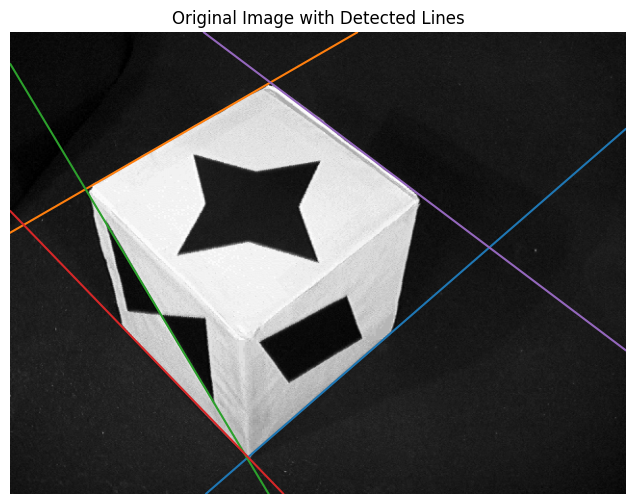

In [8]:
plt.figure(figsize=(8, 6))
plt.imshow(box, cmap='gray')
plt.title('Original Image with Detected Lines')
plt.axis('off')


for angle, dist in zip(angles_peaks, dists_peaks):
    
    a = np.cos(angle)
    b = np.sin(angle)
    c = -dist
    l = np.array([a, b, c])
    DrawLine(l, box.shape)

plt.show()

## RANSAC
Here you should fit a line to a data set consisting of inliers with noise and outliers. Such data is
generated by the following function:

In [9]:
def test_points(n_in, n_out):
    """
    Generate data set consisting of inliers with noise and outliers.

    Args:
        n_in: number of inliers
        n_out: number of outliers

    Returns:
        points: 2x(n_in+n_out) array of points
    """
    # inliers: points along y=0.5*x+b
    a = (np.random.rand(n_in) - 0.5) * 10  # [-5, 5]
    b = np.vstack((a, a * 0.5 + np.random.randn(n_in) * 0.25))  # add 0.25 noise
    # outliers: random points
    points = np.hstack((b, 2 * np.random.randn(2, n_out)))
    return np.random.permutation(points.T).T  # randomly permute points

(2, 9)


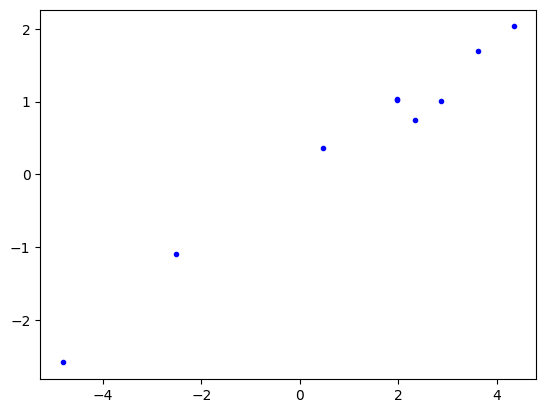

In [10]:
n_in = 7
n_out = 2
points = test_points(n_in, n_out)
print(points.shape)
plt.plot(points[0, :], points[1, :], ".b")

Exercise 7.6
Make a function that fits a line, in homogeneous coordinates, given two points

In [11]:
def est_line(p1, p2):
    return np.cross(p1, p2)
print(points.shape)
p1 = points[:, 0]
p2 = points[:, 1]
p1 = np.hstack((p1, 1))
p2 = np.hstack((p2, 1))

print(p1.shape)
C = est_line(p1, p2)
# C[0]*x + C[1]*y + C[2] = 0
# a*x + b*y + c = 0
print(C)
a = C[0]
b = C[1]
c = C[2]
a, b, c

(2, 9)
(3,)
[-1.28051746  1.993211    1.50913479]


(-1.280517456528707, 1.9932110030244736, 1.5091347884315383)

Exercise 7.7
Make a function that determines which of a set of 2D points are an inliers or outliers with respect
to a given line. The threshold should be supplied as parameter to this function, such that it can
easily be tuned later

In [12]:
def is_inliner(point, line, threshold):
    line=line.copy()
    point=point.copy()
    # First we normalize a^2 + b^2 = 1
    a = line[0]
    b = line[1]
    scale = np.sqrt(a**2 + b**2)
    line/= scale

    # Then we can calculate distance to line:
    dist = np.abs(line.T@point)
    return dist<threshold

print(is_inliner(p1, C, 1))
print(is_inliner(p2, C, 1))
print(p1.shape, (C.T).shape)
print(is_inliner(np.array([5, 5, 1]), C, 1))
# NB! Both the homogenous points and the line is all scale invariant!
print(is_inliner(p1*15, C, 1))
print(is_inliner(p2, C*15, 1))

True
True
(3,) (3,)
False
True
True


Exercise 7.8
Make a function that calculates the consensus, i.e. the number of inliers, for a line with respect to
a set of points

In [13]:
def consensus(line, points, threshold=1):
    '''
    Line is a homogenous line.
    Points is set of inhomogenous points.
    TODO: get rid of for loop.
    '''
    no = 0
    for i in range(len(points[0])):
        point = np.array([points[0, i],
                          points[1, i],
                          1])
        if is_inliner(point, line, threshold=threshold):
            no+=1
    return no

In [14]:
tau = 0.2
print(l.shape)
n_inliners = consensus(l, points, tau)
print(f"no. of inliners: {n_inliners}")

(3,)
no. of inliners: 0


Exercise 7.9
Make a function that randomly samples two of n 2D points (without replacement).

In [15]:
def drawTwo(points):
    indexes = np.random.choice(len(points[0]), 2)
    return points[:, indexes]

In [16]:
p1, p2 = drawTwo(points)

p2

array([1.02891664, 0.75112892])

Exercise 7.10
Assemble the functions made above to a working RANSAC algorithm for estimating lines. Set the
number of iterations and the threshold manually
```Python
C[0]*x + C[1]*y + C[2] = 0
a*x + b*y + c = 0
y = 1/b(-a*x - c)
```

In [17]:
def RANSAC_simple(points, threshold=1, iterations=10):
    best_inliers = 0
    best_line = None
    for i in range(iterations):
        # Draw two random points
        p1, p2 = drawTwo(points)
        p1 = np.hstack((p1, 1))
        p2 = np.hstack((p2, 1))
        # Estimate the line
        line = est_line(p1, p2)
        # Find no. inliers
        no_inliers = consensus(line, points, threshold=threshold)
        if no_inliers>best_inliers:
            best_line = line.copy()
            best_inliers = no_inliers
    print(f'Best line found: {best_line}')
    print(f'with num of inliers: {best_inliers}')
    return best_line, no_inliers

Best line found: [ 0.94276713 -2.30928211  0.45153152]
with num of inliers: 5
equation of the line: [ 0.94276713 -2.30928211  0.45153152]
no. of inliners: 0


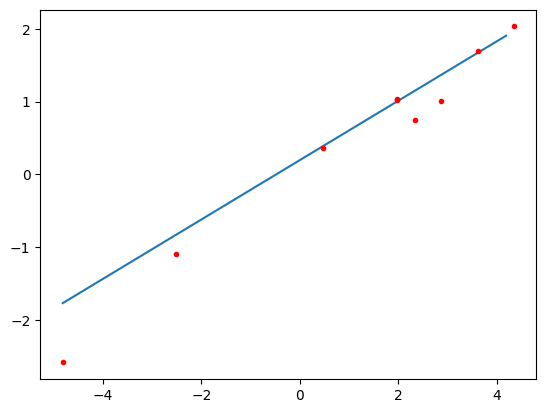

In [18]:
best_line, no_inliers = RANSAC_simple(points, threshold=0.2, iterations=100)
print(f"equation of the line: {best_line}")
print(f"no. of inliners: {no_inliers}")
a = best_line[0]
b = best_line[1]
c = best_line[2]

xs = np.arange(points[0,:].min(), points[0,:].max())
plt.plot(xs, 1/b*(-a*xs - c))
plt.plot(points[0, :], points[1, :], ".r")

Exercise 7.11
Experiment with the algorithm, what is a good threshold for distinguishing between inliers and
outliers

**Threshold** If it is too big, then the "best line" will just be any line pointing in more or less the right direction. If it is too small then any line will be equally bad and the results are random.

Using 1/4 the thickness of the shape of the points seems to be nice.

Exercise 7.12
Add the final step to your implementation, where you fit a new line to all inliers of the best
line. The total least squares fit of a straight line to a set of points is given by the first principal
component of them. Consider using the code below to get a homogeneous line along the first
principal component.

In [24]:
def pca_line(x): #assumes x is a (2 x n) array of points
    d = np.cov(x)[:, 0]
    d /= np.linalg.norm(d)
    l = [d[1], -d[0]]
    l.append(-(l@x.mean(1)))
    return l


def RANSAC_fit(points, threshold=1, iterations=500):
    best_inliers = 0
    best_line = None
    for i in range(iterations):
        # Draw two random points
        p1, p2 = drawTwo(points)
        p1 = np.hstack((p1, 1))
        p2 = np.hstack((p2, 1))
        # Estimate the line
        line = est_line(p1, p2)
        # Find no. inliers
        no_inliers = consensus(line, points, threshold=threshold)
        if no_inliers>best_inliers:
            best_line = line.copy()
            best_inliers = no_inliers
    # We now have the best line. Extract inliners and fit.
    print(f'Best line found: {best_line}')
    best_i = []
    for i in range(len(points[0])):
        p = np.hstack((points[:, i], 1))
        if is_inliner(p, best_line, threshold=threshold):
            best_i.append(i)
    best_points = points[:, best_i]
    print(f"no. of best_inliners: {best_points.shape[1]}")
    fit_line = pca_line(best_points)
    return fit_line, best_points

(2, 20)
Best line found: [ 0.8712041  -1.6537837  -0.08675609]
no. of best_inliners: 9


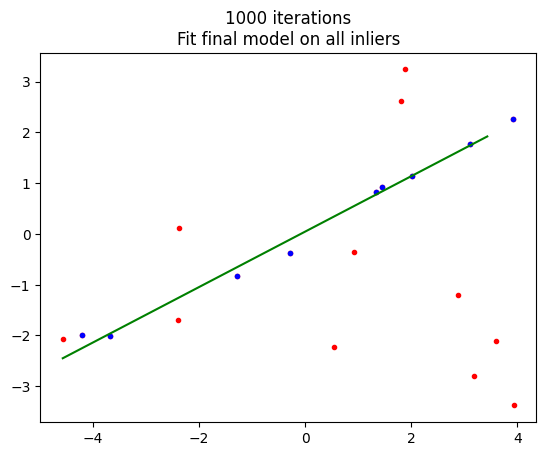

In [25]:
print(points.shape)
fit_line, best_points = RANSAC_fit(points, threshold=0.3, iterations=1000)
xs = np.arange(points[0,:].min(), points[0,:].max())
a = fit_line[0]
b = fit_line[1]
c = fit_line[2]

plt.plot(points[0, :], points[1, :], ".r")
plt.plot(best_points[0, :], best_points[1, :], ".b")
plt.plot(xs, 1/b*(-a*xs - c), "g")
plt.title(str(1000)+" iterations\nFit final model on all inliers");

Exercise 7.13
Implement the stopping criteria for RANSAC as described on the slides. Use p = 0.99.

- $\epsilon$ is relative share of outliers in data.
- n is the datapoints in one sample: DoF of the model we want to fit.
- p is the probability of having at least one sample with no outliers

>    P(one sample has only inliers) = (1-$\epsilon$)^n \
>    P(one sample has one or more outliers) = 1 - (1-$\epsilon$)^n \
>    P(each of N samples all have one or more outliers) = (1 - (1-$\epsilon$)^n)^N \
>    P(at least one of N sample has only inliers) = 1 - ((1 - (1-$\epsilon$)^n)^N) = p \

- Run the algorithm until N samples has been tested: $N = \frac{log(1-p)}{log(1-(1-\epsilon)^n)}$ => p is guaranteed.

- Often, you do not know epsilon. Then use eps_hat = 1 - s/m as an estimation, where s is the most no. of inliers found so far, and m is total no. of points. This will be an upper limit of epsilon and guarantees that we get at least p accuracy.

In [29]:
def RANSAC_epsilon(points, threshold, p=0.99):
    best_inliers = 0
    best_line = None
    
    m = len(points[0])
    iteration = 0 # Current iteration
    N_hat = 1000 # Iterations needed to achieve p
    epsilon_hat = 1
    while iteration<N_hat:
        # Draw two random points
        p1, p2 = drawTwo(points)
        p1 = np.hstack((p1, 1))
        p2 = np.hstack((p2, 1))
        # Estimate the line
        line = est_line(p1, p2)
        # Find no. inliers
        no_inliers = consensus(line, points, threshold=threshold)
        if no_inliers>best_inliers:
            best_line = line.copy()
            best_inliers = no_inliers
            # Should we stop?
            epsilon_hat = 1 - best_inliers/m
            N_hat = np.log(1 - p) / np.log(1 - (1 - epsilon_hat)**2)
            print("eps_hat:", epsilon_hat, " ==> \tN-hat", N_hat, end="\n")
            print(f'Best line found: {best_line}')

        iteration += 1
    # We now have the best line. Extract inliners and fit.
    best_i = []
    for i in range(len(points[0])):
        p = np.hstack(        
            (points[:, i], 1))
        if is_inliner(p, best_line, threshold=threshold):
            best_i.append(i)
    best_points = points[:, best_i]
    
    fit_line = pca_line(best_points)
    print(f'Best line found: {best_line}') 
    print(f"no. of best_inliners: {best_points.shape[1]}")
    print(f'and num of iterations: {iteration}')
    return fit_line, best_points, iteration

In [30]:
points = test_points(10, 10)
fit_line, best_points, iteration = RANSAC_epsilon(points, threshold=0.1, p=0.99)

eps_hat: 0.95  ==> 	N-hat 1839.764528690579
Best line found: [ 0.17198497 -1.6207144   2.25688268]
eps_hat: 0.9  ==> 	N-hat 458.2105765533884
Best line found: [0.36790635 2.61576507 1.29194437]
eps_hat: 0.85  ==> 	N-hat 202.3629121541935
Best line found: [-2.60785596 -0.36790635  0.28001383]
Best line found: [-2.60785596 -0.36790635  0.28001383]
no. of best_inliners: 3
and num of iterations: 203


Text(0.5, 1.0, 'Confidence of 99%\nRan for 203 iteration')

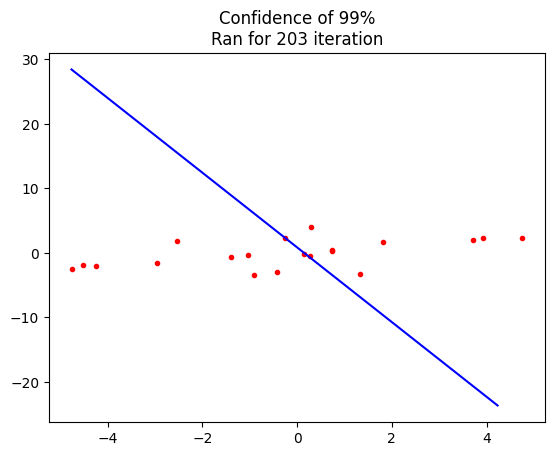

In [31]:
xs = np.arange(points[0,:].min(), points[0,:].max())
a = fit_line[0]
b = fit_line[1]
c = fit_line[2]

plt.plot(points[0, :], points[1, :], ".r")
#plt.plot(best_points[0, :], best_points[1, :], ".r")
plt.plot(xs, 1/b*(-a*xs - c), "b")
plt.title(f"Confidence of 99%\nRan for {iteration} iteration")

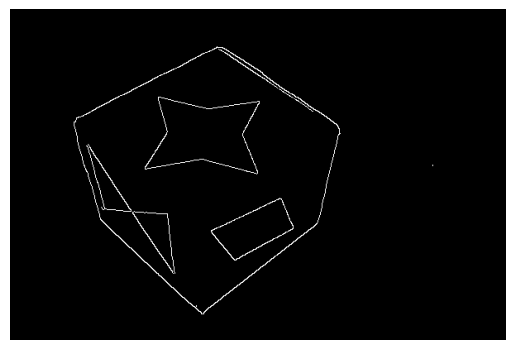

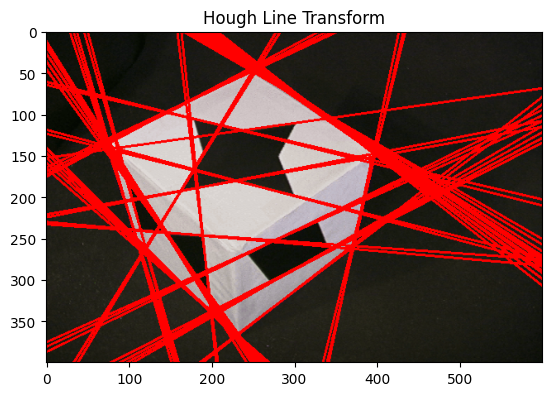

In [41]:
def hough_transform_line_detection(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Use the Canny edge detector to find edges
    edges = cv2.Canny(gray, 50, 300)
    plt.imshow(edges, cmap='gray')
    plt.axis('off')
    plt.show()
    # Use the Hough Line Transform to find lines
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 50)
    
    # Draw the lines on the image
    for line in lines:
        rho, theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        cv2.line(image, (x1, y1), (x2, y2), (0, 0, 255), 2)
    
    return image

# Load image
image = cv2.imread('images/Box3.bmp')
image = cv2.resize(image, (600, 400))

# Detect lines using Hough Transform
hough_lines_image = hough_transform_line_detection(image.copy())

# Show the result
plt.imshow(cv2.cvtColor(hough_lines_image, cv2.COLOR_BGR2RGB))
plt.title('Hough Line Transform')
plt.show()

![alt text](<images/image copy 3.png>)

![alt text](<images/image copy 4.png>)